# Building and Tuning an RNN Model with LSTM to predict if stock price moves up or down the following trading day

## 1.) Importing asset price from Yahoo Finance

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
#picking Amazon stock
#time period: post 2010
stock_data = yf.download("AMZN", start="2010-01-01", end="2022-12-31")

# Preprocess data
# scaling using pct_change as it is time series data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)   #reshape(-1,1) means 1 col,u figure out rows

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04 00:00:00-05:00,6.812500,6.830500,6.657000,6.695000,6.695000,151998000
2010-01-05 00:00:00-05:00,6.671500,6.774000,6.590500,6.734500,6.734500,177038000
2010-01-06 00:00:00-05:00,6.730000,6.736500,6.582500,6.612500,6.612500,143576000
2010-01-07 00:00:00-05:00,6.600500,6.616000,6.440000,6.500000,6.500000,220604000
2010-01-08 00:00:00-05:00,6.528000,6.684000,6.451500,6.676000,6.676000,196610000
...,...,...,...,...,...,...
2022-12-23 00:00:00-05:00,83.250000,85.779999,82.930000,85.250000,85.250000,57433700
2022-12-27 00:00:00-05:00,84.970001,85.349998,83.000000,83.040001,83.040001,57284000
2022-12-28 00:00:00-05:00,82.800003,83.480003,81.690002,81.820000,81.820000,58228600


## 2.) Creating x_train/y_train data so that the RNN uses percentage change data to make a binary forecast

In [4]:
train_data

array([[ 0.00589989],
       [-0.01811563],
       [-0.01701326],
       ...,
       [-0.00402982],
       [-0.00616361],
       [-0.00473604]])

In [82]:
x_train = []
y_train = []

input_size = 5   #depicts the number of time lags   #so using a week (5 trading days)
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(np.where(train_data[i, 0] > 0, 1,0))


x_train, y_train = np.array(x_train), np.array(y_train)
#reshaping input because RNN model needs 3rd dimension too (input_dim)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))    #3rd dimension is 1 since univariate TS
#shape is -- num_samples, input_size, input_dim

In [252]:
pd.Series(y_train).value_counts()   #shows that the output data is almost balanced

1    1390
0    1221
dtype: int64

## Building an RNN Architecture

In [158]:
model = Sequential()

#adding LSTM layer
model.add(LSTM(50, return_sequences=False, input_shape=(x_train.shape[1], 1)))
#LSTM(no.of neurons--hyperparameter-to be tuned, useful to stack multiple lstm layers, (no.of time steps, no.of features))

#adding another LSTM layer
#model.add(LSTM(150, return_sequences=False))

model.add(Dense(25))
#model.add(Dropout(0.3))   #to prevent overfitting
model.add(Dense(1, activation='sigmoid'))       #output   

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])   
#adam implies adaptive learning rates

model.fit(x_train, y_train, epochs=15)    

Epoch 1/15
82/82 [==============================] - 5s 7ms/step - loss: 0.6918 - accuracy: 0.5205
Epoch 2/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6915 - accuracy: 0.5324
Epoch 3/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6915 - accuracy: 0.5324
Epoch 4/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6915 - accuracy: 0.5324
Epoch 5/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6913 - accuracy: 0.5324
Epoch 6/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6913 - accuracy: 0.5324
Epoch 7/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6915 - accuracy: 0.5324
Epoch 8/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6914 - accuracy: 0.5324
Epoch 9/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6914 - accuracy: 0.5324
Epoch 10/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6913 - accuracy: 0.5324
Epoch 11/15
82/82 [

In [159]:
predictions = model.predict(x_train)

82/82 [==============================] - 1s 4ms/step


In [165]:
predictions

array([[0.53033024],
       [0.53118724],
       [0.52905756],
       ...,
       [0.5299061 ],
       [0.5297766 ],
       [0.52986085]], dtype=float32)

In [164]:
#converting the output to binary to see if stock goes up or down the next day
y_pred_binary = (predictions > 0.5).astype(int)

In [167]:
np.unique(y_pred_binary)

array([0, 1])

Shows that the output has binary outcomes!

## 3.) Testing the model: Comparing insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy

In [176]:
test_data = scaled_data[training_data_len - input_size:, :]

In [177]:
x_test = []
y_test = []

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    y_test.append(np.where(test_data[i, 0] > 0, 1,0))

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))    #3rd dimension is 1 since univariate TS
#shape is -- num_samples, input_size, input_dim

In [179]:
from sklearn.metrics import accuracy_score

In [260]:
#in sample accuracy
predictions = model.predict(x_train)
y_pred_binary = (predictions > 0.588).astype(int)
insample_acc = accuracy_score(y_train, y_pred_binary)

#in sample random walk accuracy
#y_train[:-1]   #actual
#y_train[1:]    #predicted
insample_rand_acc = accuracy_score(y_train[:-1], y_train[1:])
print("The in sample model accuracy is:", insample_acc)
print("The in sample random walk model accuracy is:", insample_rand_acc)

82/82 [==============================] - 0s 3ms/step
The in sample model accuracy is: 0.46763692072003066
The in sample random walk model accuracy is: 0.4957854406130268


In [259]:
#out sample accuracy
oos_predictions = model.predict(x_test)
oos_y_pred_binary = (oos_predictions > 0.588).astype(int)
outsample_acc = accuracy_score(y_test, oos_y_pred_binary)

#out sample random walk accuracy
#y_test[:-1]   #actual
#y_test[1:]    #predicted
outsample_rand_acc = accuracy_score(y_test[:-1], y_test[1:])

print("The out of sample model accuracy is:", outsample_acc)
print("The out of sample random walk model accuracy is:", outsample_rand_acc)

21/21 [==============================] - 0s 3ms/step
The out of sample model accuracy is: 0.49770992366412214
The out of sample random walk model accuracy is: 0.5198776758409785


In [261]:
data = {'In_Acc':insample_acc, 'In_RW_Acc':insample_rand_acc, 'Out_Acc':outsample_acc, 'Out_RW_Acc':outsample_rand_acc}
metrics = list(data.keys())
values = list(data.values())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

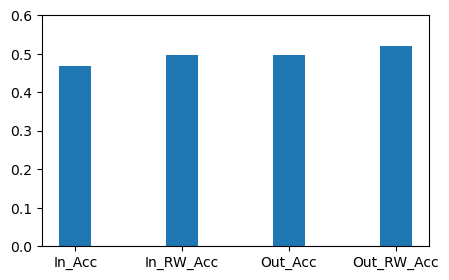

In [263]:
plt.figure(figsize = (5, 3))
plt.bar(metrics, values, width = 0.3)
plt.ylim(0,0.6)
plt.show()

## Observation:

- We find that both in case of training and testing data, the RNN model could not perform better than the Random Walk model which assumes that the best prediction is the previous observed value.
- A surprising result though, is the improved accuracy of the model on testing data compared to training data - this is not common. However, this is no indication of a great model as the classifications are almost random!


## 4.) Creating a parameter for number of lags in the input layer. Running a 3-fold CV to test three different time lags of previous price data to forecast

In [187]:
import warnings
warnings.filterwarnings("ignore")

In [243]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
#globally changing my training sets

In [241]:
def create_model(input_size=4):
    # Update training data with the best input size
    global x_train_new
    global y_train_new
    
    x_train_new = []
    y_train_new = []
    for i in range(input_size, len(train_data)):
        x_train_new.append(train_data[i-input_size:i, 0])
        y_train_new.append(np.where(train_data[i, 0] > 0, 1,0))

    x_train_new, y_train_new = np.array(x_train_new), np.array(y_train_new)
    x_train_new = np.reshape(x_train_new, (x_train_new.shape[0], x_train_new.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(input_size-1, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {'batch_size': [10, 20, 100],
              'epochs': [5, 10],
              'input_size': [1,3, 5]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_result = grid.fit(x_train, y_train)

print("Best accuracy: %f using %s from original training data" % (grid_result.best_score_, grid_result.best_params_))

Best accuracy: 0.532144 using {'batch_size': 10, 'epochs': 5, 'input_size': 3} from original training data


This shows that the highest accuracy can be achieved with an input size of 3 lags, batch size of 10 samples and running the model with 5 epochs. This can be tuned further to test for higher epoch values but an accuracy of 53% is much higher than the original model. Further, accuracy may not be the best measure, we could try AUC and other metrics as well!

In [185]:
#trial with above code +neurons

In [247]:
def create_model(input_size=4, neurons=30):
    # Update training data with the best input size
    global x_train_new
    global y_train_new
    
    x_train_new = []
    y_train_new = []
    for i in range(input_size, len(train_data)):
        x_train_new.append(train_data[i-input_size:i, 0])
        y_train_new.append(np.where(train_data[i, 0] > 0, 1,0))

    x_train_new, y_train_new = np.array(x_train_new), np.array(y_train_new)
    x_train_new = np.reshape(x_train_new, (x_train_new.shape[0], x_train_new.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=False, input_shape=(input_size-1, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {'batch_size': [10, 20, 100],
              'epochs': [5, 10],
              'input_size': [2,3, 5],
             'neurons': [10,25,50]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_result = grid.fit(x_train, y_train)

print("Best accuracy: %f using %s from original training data" % (grid_result.best_score_, grid_result.best_params_))

Best accuracy: 0.532144 using {'batch_size': 10, 'epochs': 5, 'input_size': 3, 'neurons': 10} from original training data
